In [1]:
import pandas as pd
import re
from nltk.stem import WordNetLemmatizer
import numpy as np
from scipy.stats import skew, kurtosis, mode
from wordcloud import WordCloud

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = (9, 9)

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc

## Data Wrangling

In [4]:
def getWhatsCookingData(jsonFile):
    """Takes a .json file and returns a dataframe whose columns are the cuisines(the targets)
    , and two columns with different ways of presenting the ingredients(the features).
    The memory used by the dataframe is well below 100 MB.
    In a previous version I used natural language processing, but it didn't improve the accuracy."""
    
    df = (pd
          .read_json(jsonFile)
          .set_index('id'))
    
    df['cuisine'] = (df['cuisine']
                     .astype('category'))
    
    df['ingredients_str1'] = [' '.join(lists).strip() for lists in df['ingredients']]
    
    df['ingredients_str2'] = [' '
                              .join([WordNetLemmatizer()
                                     .lemmatize(re
                                                .sub('[^A-Za-z]', ' ', line)) for line in lists])
                              .strip() for lists in df['ingredients']]
    
    df['ingredients_str3'] = [' '
                              .join([WordNetLemmatizer()
                                     .lemmatize(re
                                                .sub('[^A-Za-z]', ' ', line)) for line in strs
                                     .split()]) for strs in df['ingredients_str1']]
    
    return df

In [5]:
traindf = getWhatsCookingData('train.json')

In [6]:
traindf.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39774 entries, 10259 to 2362
Data columns (total 5 columns):
cuisine             39774 non-null category
ingredients         39774 non-null object
ingredients_str1    39774 non-null object
ingredients_str2    39774 non-null object
ingredients_str3    39774 non-null object
dtypes: category(1), object(4)
memory usage: 28.3 MB


In [7]:
traindf.head()

,cuisine,ingredients,ingredients_str1,ingredients_str2,ingredients_str3
id,,,,,
10259,greek,"[romaine lettuce, black olives, grape tomatoes...",romaine lettuce black olives grape tomatoes ga...,romaine lettuce black olives grape tomatoes ga...,romaine lettuce black olive grape tomato garli...
25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",plain flour ground pepper salt tomatoes ground...,plain flour ground pepper salt tomato ground b...,plain flour ground pepper salt tomato ground b...
20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",eggs pepper salt mayonaise cooking oil green c...,egg pepper salt mayonaise cooking oil green ch...,egg pepper salt mayonaise cooking oil green ch...
22213,indian,"[water, vegetable oil, wheat, salt]",water vegetable oil wheat salt,water vegetable oil wheat salt,water vegetable oil wheat salt
13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",black pepper shallots cornflour cayenne pepper...,black pepper shallot cornflour cayenne pepper ...,black pepper shallot cornflour cayenne pepper ...


## Exploratory Analysis

What are the different cuisines?

In [8]:
cuisineCounts = traindf['cuisine'].value_counts()

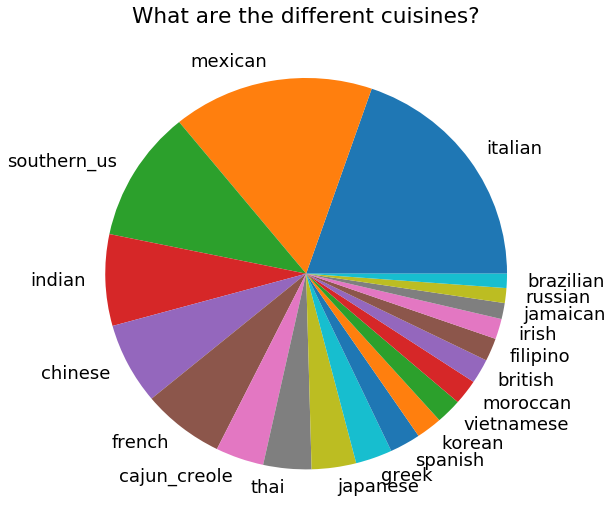

In [9]:
plt.figure()
plt.pie(cuisineCounts, labels = cuisineCounts.keys())
plt.title('What are the different cuisines?')
plt.show()

How many ingredients in each recipe?

In [10]:
ingredient_list_len = traindf['ingredients'].str.len()

In [11]:
stats_labels = ['mean', 'median', 'standard deviation', 'skew', 'kurtosis', 'mode']

In [12]:
def creates_stats_str(list_len):
    stats = [np.mean(list_len),
             np.median(list_len),
             np.std(list_len),
             skew(list_len),
             kurtosis(list_len),
             mode(list_len)[0][0]]
    stats_str = ('\n'.join([stats_labels[i] + ' = ' + str(np.round(stats[i], decimals = 1)) 
                             for i in range(len(stats_labels))]))
    return stats_str

In [13]:
desc_stats_str = creates_stats_str(ingredient_list_len)

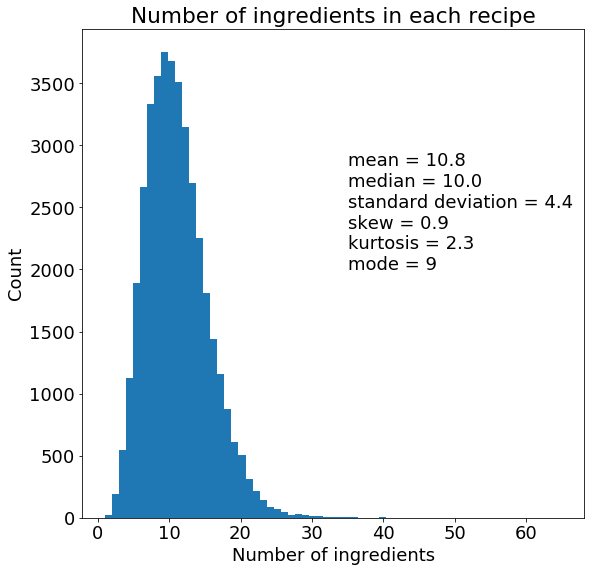

In [14]:
plt.figure()
plt.hist(ingredient_list_len, bins = np.max(ingredient_list_len))
plt.xlabel('Number of ingredients')
plt.ylabel('Count')
plt.title('Number of ingredients in each recipe')
plt.text(35, 2000, desc_stats_str)
plt.show()

Most common ingredients:

In [15]:
def ingredients_commonness(column):
    se = (column
          .apply(pd.Series)
          .stack()
          .reset_index(drop = True)
          .astype('category'))
    return se.value_counts()

In [16]:
ingred_VC = ingredients_commonness(traindf['ingredients'])

In [17]:
ingredS1_VC = ingredients_commonness(traindf['ingredients_str1'].str.split())

In [18]:
ingredS2_VC = ingredients_commonness(traindf['ingredients_str2'].str.split())

In [19]:
ingredS3_VC = ingredients_commonness(traindf['ingredients_str3'].str.split())

In [48]:
def ingredient_word_cloud(ingredient_values):
    wclist = [(ingredient, ingredient_values[ingredient]
               .astype(float)) for ingredient in ingredient_values.keys()]
    wc = WordCloud().generate_from_frequencies(wclist)

    plt.imshow(wc.to_array(), interpolation = 'bilinear')
    plt.title('Most common ingredients')
    plt.axis('off') 
    plt.show()

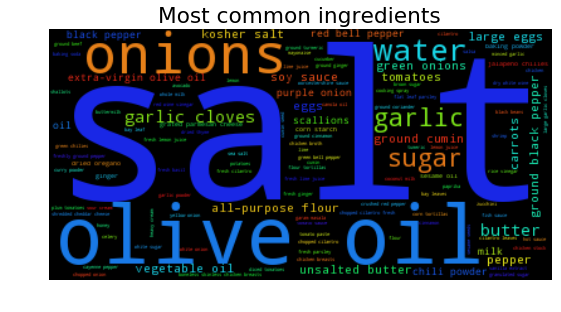

In [49]:
ingredient_word_cloud(ingred_VC)

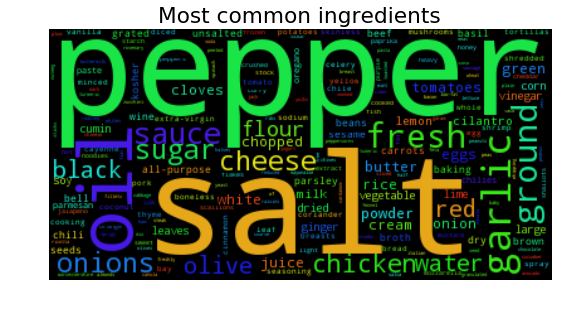

In [50]:
ingredient_word_cloud(ingredS1_VC)

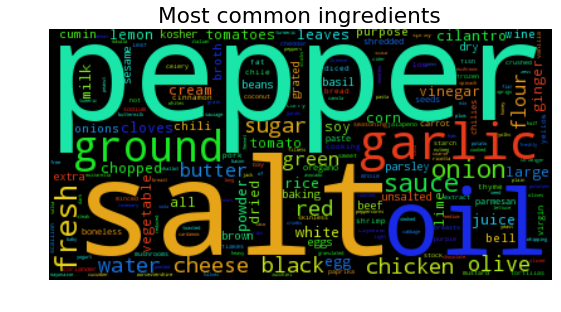

In [51]:
ingredient_word_cloud(ingredS2_VC)

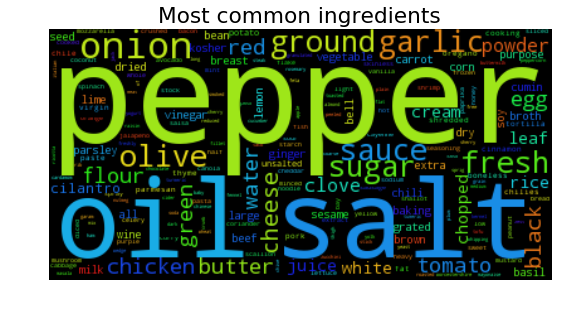

In [52]:
ingredient_word_cloud(ingredS3_VC)

## Data Preprocessing, Modeling and Validating

In [23]:
Tfidf_vec = TfidfVectorizer(stop_words = 'english')

In [24]:
X = (Tfidf_vec
     .fit_transform(traindf['ingredients_str1']
                    .append(traindf['ingredients_str2'])
                    .append(traindf['ingredients_str3']))
     .todense())

In [25]:
y = (traindf['cuisine']
     .append(traindf['cuisine'])
     .append(traindf['cuisine']))

In [26]:
clf1 = LogisticRegression(C = 10)
clf2 = CalibratedClassifierCV(LinearSVC(dual = False))
clf3 = RandomForestClassifier()

In [27]:
eclf = VotingClassifier(estimators = [('lr', clf1), ('svc', clf2), ('rfc', clf3)],
                        voting = 'soft')

In [28]:
def cv_score(clf, label):
    score = cross_val_score(clf, X, y, cv = 3, scoring = 'accuracy')
    return "Accuracy: %0.3f (+/- %0.3f) [%s]" % (score.mean(), score.std(), label)

In [29]:
cv_score(clf1, 'Logistic Regression')

'Accuracy: 0.852 (+/- 0.007) [Logistic Regression]'

In [30]:
cv_score(clf2, 'Support Vector Machine')

'Accuracy: 0.849 (+/- 0.006) [Support Vector Machine]'

In [31]:
cv_score(clf3, 'Random Forest')

'Accuracy: 0.979 (+/- 0.012) [Random Forest]'

In [32]:
cv_score(eclf, 'Ensemble')

'Accuracy: 0.919 (+/- 0.012) [Ensemble]'

In [33]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size = 0.2)

In [34]:
classifier = LinearSVC(dual = False).fit(X_train, y_train)

In [35]:
y_predict = classifier.predict(X_test)

In [36]:
conf_mat = confusion_matrix(y_test, y_predict)

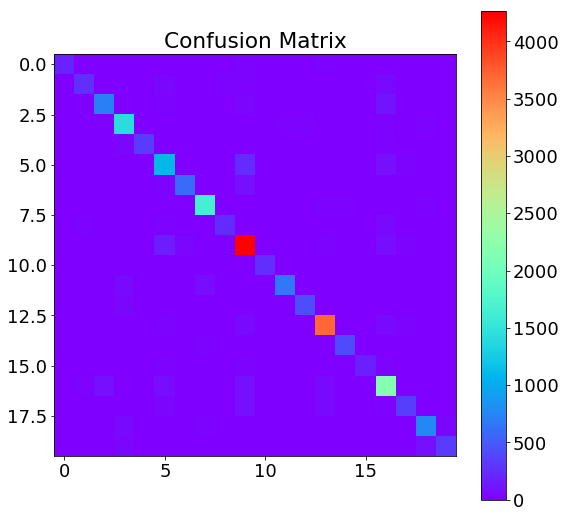

In [37]:
plt.imshow(conf_mat, cmap = plt.cm.rainbow, interpolation = 'nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.show()

In [38]:
y_score = classifier.decision_function(X_test)

In [39]:
Count_vec = CountVectorizer()

In [40]:
y_test_vec = (Count_vec
              .fit_transform(y_test)
              .toarray())

In [41]:
n_classes = len(traindf['cuisine'].cat.categories)

Compute ROC curve and ROC area for each class

In [42]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_vec[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

Compute micro-average ROC curve and ROC area

In [43]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_vec.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [44]:
def ROCplot(index, color):
    plt.figure()
    plt.plot(fpr[index], tpr[index], color = color, 
             lw = 2, label = 'ROC curve (area = %0.2f)' % roc_auc[index])
    plt.plot([0, 1], [0, 1], color = 'gray', lw = 2, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve %s' % traindf['cuisine'].cat.categories[index])
    plt.legend(loc = 'lower right')
    plt.show()

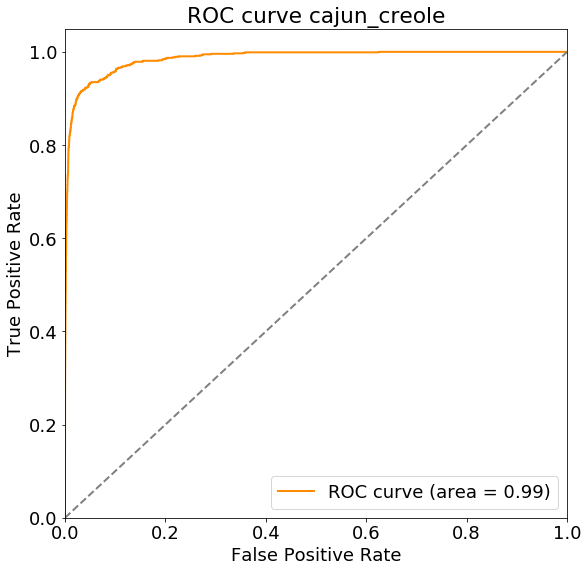

In [45]:
ROCplot(2, 'darkorange')

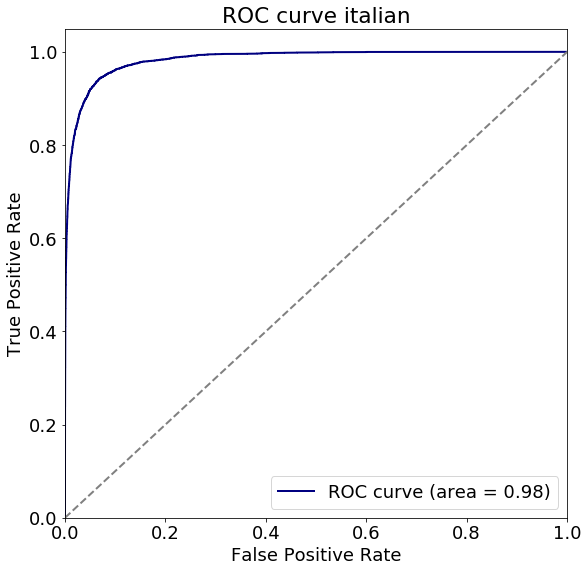

In [46]:
ROCplot(9, 'navy')

## Cuisine Suggestions

In [55]:
def cuisine_suggestions_dict():
    cats = (traindf['cuisine']
            .cat
            .categories)
    return dict(zip(cats.tolist(),
                    [[cats[a.tolist().index(sorted(a, reverse = True)[x])] 
                      for x in range(1, 4)] for a in conf_mat]))

In [56]:
sugs_dict = cuisine_suggestions_dict()

In [63]:
def cuisine_suggestions(cuisine, n_sugs=1):
    return sugs_dict[cuisine][:n_sugs]

In [69]:
cuisine_suggestions('russian', 2)

['southern_us', 'french']